In [422]:
from pymongo import MongoClient
import json
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
import copy
import os
import subprocess
import re
import numpy as np
from datetime import date
import dash
import dash_table
import plotly.express as px

In [330]:
with open("example_master.json", "r") as read_file:
    example_json = json.load(read_file)


In [321]:
example_json["incremental_plots"]["confirmed"]

{'data': [{'x': ['2020-03-11', '2020-03-12', '2020-03-13'],
   'y': [220, 320, 350],
   'type': 'bar'}],
 'layout': {'xaxis': {'title': 'Date'},
  'yaxis': {'title': 'Cases', 'type': 'linear'},
  'margin': {'l': 40, 'b': 40, 't': 10, 'r': 0},
  'hovermode': 'closest'}}

In [ ]:
# Every state should be an object
# Every state will have a name
# -- Every state will have an incremental and a cumulative
# -- -- Every cumulative will be split into the sub plots
# -- -- Subplots: Deaths, Cases, Test Rates, Tests Administered
# -- -- Plots will be named as such

# Create Testing Plots

In [242]:
testing = pd.read_csv("/Users/CharlesFederici/corona_python/data/testing.csv")
states = pd.read_csv("/Users/CharlesFederici/corona_python/dash_app/states.csv").rename({"State":'state_full'}, axis="columns")
testing = testing.merge(states, how="left", left_on=['state'], right_on=["Abbreviation"])
testing['dataQualityGrade'] = testing['dataQualityGrade'].str.extract(r'([A-Z])')
testing['dataQualityGrade'] = testing['dataQualityGrade'].fillna('NA')


testing['tests'] = testing['positive'] + testing['negative']
testing['positive_rate'] = testing['positive'] / testing['tests']

testing['incremental_tests'] = testing['positiveIncrease'] + testing['negativeIncrease']
testing['incremental_positive_rate'] = testing['positiveIncrease'] / (testing['positiveIncrease'] + testing['negativeIncrease'])

In [243]:
blue_color_mapping = {'F':"#eff3ff", 'NA':"#eff3ff", 'D': '#bdd7e7', 'C':'#6baed6', 'B':'#3182bd', 'A':'#08519c'}
green_color_mapping = {'F':"#edf8e9", 'NA':"#edf8e9",'D': '#bae4b3', 'C':'#74c476', 'B':'#31a354', 'A':'#006d2c'}

testing['positive_rate_color'] = testing['dataQualityGrade'].replace(blue_color_mapping)
testing['incremental_positive_rate_color'] = testing['dataQualityGrade'].replace(green_color_mapping)

In [311]:
def create_hover_text_rate(date, positive_rate, data_quality_score, incremental):
    #  Date:2020-06-18 <br> Positive Rate: 5.1% <br> Data Quality: A
    date_tag = "Date: " + date
    if incremental:
        positive_tag = "Incremental Positive Rate: " + np.round_(positive_rate*100, 1).astype(str) + "%"
    else:
        positive_tag  = "Cumulative Positive Rate: " + np.round_(positive_rate*100, 1).astype(str) + "%"
    data_quality_tag = "Data Quality Grade: " + data_quality_score
    return(date_tag + "<br>" + positive_tag + "<br>" + data_quality_tag)
    
    
def create_hover_text_counts(date, counts, data_quality_score, incremental):
    #  Date:2020-06-18 <br> Incremental Test: 500 <br> Data Quality: A
    date_tag = "Date: " + date
    if incremental:
        tests_tag = "Incremental Tests: " + np.round((counts/1000), 3).astype(str) + " K"
    else:
        tests_tag  = "Cumulative Tests: " + np.round((counts/1000), 3).astype(str) + " K"
    data_quality_tag = "Data Quality Grade: " + data_quality_score
    return(date_tag + "<br>" + tests_tag + "<br>" + data_quality_tag)

# create_hover_text("2020-06-18", .051234422, "A", True)

In [312]:
testing["positive_rate_flag"] = create_hover_text_rate(testing["date"], testing["positive_rate"], testing['dataQualityGrade'], False)
testing["incremental_positive_rate_flag"] = create_hover_text_rate(testing["date"], testing["incremental_positive_rate"], testing['dataQualityGrade'], True)

testing["tests_flag"] = create_hover_text_counts(testing["date"], testing["tests"], testing['dataQualityGrade'], False)
testing["incremental_tests_flag"] = create_hover_text_counts(testing["date"], testing["incremental_tests"], testing['dataQualityGrade'], True)

In [313]:
ny_tests = testing[testing["state_full"]=="New York"].sort_values(['date'])

In [314]:
ny_tests

,Unnamed: 0,date,state,positive,negative,positiveIncrease,negativeIncrease,dataQualityGrade,state_full,Abbreviation,tests,positive_rate,incremental_tests,incremental_positive_rate,positive_rate_color,incremental_positive_rate_color,positive_rate_flag,incremental_positive_rate_flag,tests_flag,incremental_tests_flag
5842,5842,2020-03-04,NY,6.0,48.0,0,0,NA,New York,NY,54.0,0.111111,0,NaN,#eff3ff,#edf8e9,Date: 2020-03-04<br>Cumulative Positive Rate: ...,Date: 2020-03-04<br>Incremental Positive Rate:...,Date: 2020-03-04<br>Cumulative Tests: 0.054 K<...,Date: 2020-03-04<br>Incremental Tests: 0.0 K<b...
5824,5824,2020-03-05,NY,22.0,76.0,16,28,NA,New York,NY,98.0,0.224490,44,0.363636,#eff3ff,#edf8e9,Date: 2020-03-05<br>Cumulative Positive Rate: ...,Date: 2020-03-05<br>Incremental Positive Rate:...,Date: 2020-03-05<br>Cumulative Tests: 0.098 K<...,Date: 2020-03-05<br>Incremental Tests: 0.044 K...
5797,5797,2020-03-06,NY,33.0,92.0,11,16,NA,New York,NY,125.0,0.264000,27,0.407407,#eff3ff,#edf8e9,Date: 2020-03-06<br>Cumulative Positive Rate: ...,Date: 2020-03-06<br>Incremental Positive Rate:...,Date: 2020-03-06<br>Cumulative Tests: 0.125 K<...,Date: 2020-03-06<br>Incremental Tests: 0.027 K...
5757,5757,2020-03-07,NY,76.0,92.0,43,0,NA,New York,NY,168.0,0.452381,43,1.000000,#eff3ff,#edf8e9,Date: 2020-03-07<br>Cumulative Positive Rate: ...,Date: 2020-03-07<br>Incremental Positive Rate:...,Date: 2020-03-07<br>Cumulative Tests: 0.168 K<...,Date: 2020-03-07<br>Incremental Tests: 0.043 K...
5707,5707,2020-03-08,NY,105.0,92.0,29,0,NA,New York,NY,197.0,0.532995,29,1.000000,#eff3ff,#edf8e9,Date: 2020-03-08<br>Cumulative Positive Rate: ...,Date: 2020-03-08<br>Incremental Positive Rate:...,Date: 2020-03-08<br>Cumulative Tests: 0.197 K<...,Date: 2020-03-08<br>Incremental Tests: 0.029 K...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,261,2020-06-14,NY,383324.0,2551275.0,694,61665,A,New York,NY,2934599.0,0.130622,62359,0.011129,#08519c,#006d2c,Date: 2020-06-14<br>Cumulative Positive Rate: ...,Date: 2020-06-14<br>Incremental Positive Rate:...,Date: 2020-06-14<br>Cumulative Tests: 2934.599...,Date: 2020-06-14<br>Incremental Tests: 62.359 ...
205,205,2020-06-15,NY,383944.0,2607266.0,620,55991,A,New York,NY,2991210.0,0.128357,56611,0.010952,#08519c,#006d2c,Date: 2020-06-15<br>Cumulative Positive Rate: ...,Date: 2020-06-15<br>Incremental Positive Rate:...,Date: 2020-06-15<br>Cumulative Tests: 2991.21 ...,Date: 2020-06-15<br>Incremental Tests: 56.611 ...
149,149,2020-06-16,NY,384575.0,2667203.0,631,59937,A,New York,NY,3051778.0,0.126017,60568,0.010418,#08519c,#006d2c,Date: 2020-06-16<br>Cumulative Positive Rate: ...,Date: 2020-06-16<br>Incremental Positive Rate:...,Date: 2020-06-16<br>Cumulative Tests: 3051.778...,Date: 2020-06-16<br>Incremental Tests: 60.568 ...
93,93,2020-06-17,NY,385142.0,2725977.0,567,58774,A,New York,NY,3111119.0,0.123795,59341,0.009555,#08519c,#006d2c,Date: 2020-06-17<br>Cumulative Positive Rate: ...,Date: 2020-06-17<br>Incremental Positive Rate:...,Date: 2020-06-17<br>Cumulative Tests: 3111.119...,Date: 2020-06-17<br>Incremental Tests: 59.341 ...


618.0

In [307]:
def create_testing_rate_plot(df, example_json, state, incremental):
    df = df[df['state_full'] == state]
    out_json = copy.deepcopy(example_json["incremental_plots"]["testing_rate"])
    
    out_json['data'][0]['x'] = df["date"].tolist()
    out_json['data'][0]['y'] = df["positive_rate"].tolist()
    
    out_json['data'][0]["type"] = "scatter"
    out_json['data'][0]["mode"] = "markers+lines" 
    # example_json["plot_contents"]['data'][0]["name"] = "Positive Rate"
    out_json['data'][0]["showlegend"] = False
    out_json['data'][0]["marker"] = {}
    out_json['data'][0]["line"] = {}
    out_json['data'][0]["line"]['color'] = '#bdd7e7'
    out_json['data'][0]["marker"]["color"] = df["positive_rate_color"].tolist()
    out_json['data'][0]["hoverinfo"] = "text"
    out_json['data'][0]["hovertext"] = df["positive_rate_flag"].tolist()
    
    out_json['data'].append({}) 
    out_json['data'][1]["x"] = df["date"].tolist()
    out_json['data'][1]["y"] = df["incremental_positive_rate"].tolist()
    out_json['data'][1]["type"] = "scatter"
    out_json['data'][1]["mode"] = "markers+lines" 
    #out_json]['data'][1]["name"] = "Incremental Positive Rate"
    out_json['data'][1]["showlegend"] = False
    out_json['data'][1]["marker"] = {}
    out_json['data'][1]["line"] = {}
    out_json['data'][1]["line"]['color'] = '#bae4b3'
    out_json['data'][1]["marker"]["color"] = df["incremental_positive_rate_color"].tolist()
    out_json['data'][1]["hoverinfo"] = "text"
    out_json['data'][1]["hovertext"] = df["incremental_positive_rate_flag"].tolist()
    
    if incremental == "incremental":
        out_json['data'][0]["marker"]["size"] = 4
    else:
        out_json['data'][1]["marker"]["size"] = 4
    
    return(out_json)

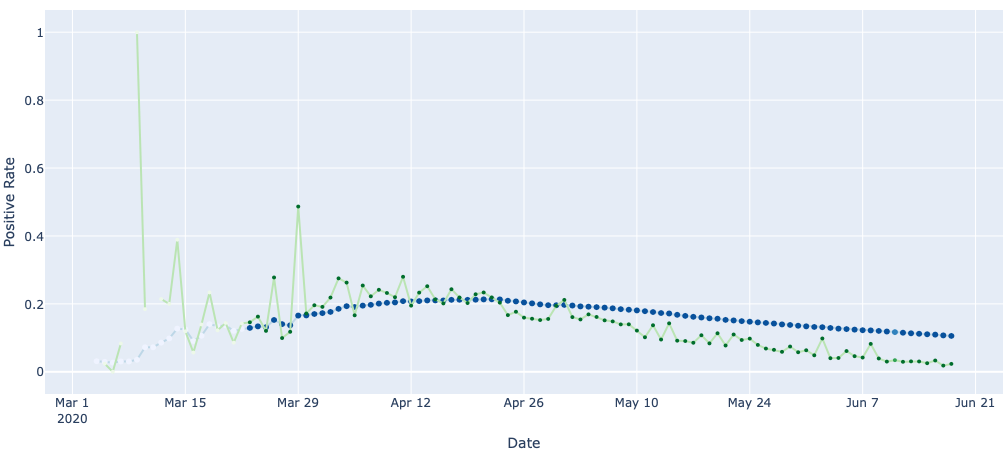

In [308]:
pio.show(create_testing_rate_plot(testing, example_json, "Illinois", "cumulative"))

In [315]:
def create_tests_administered_plot(df, example_json, state, incremental):
    df = df[df['state_full'] == state]
    if incremental == 'incremental': 
        colors = df["incremental_positive_rate_color"].tolist()
        tests = df["incremental_tests"].tolist()
        flags = df["incremental_tests_flag"].tolist()
    else:
        colors = df["positive_rate_color"].tolist()
        tests = df["tests"].tolist()
        flags = df["tests_flag"].tolist()
    
    out_json = copy.deepcopy(example_json["incremental_plots"]["tests_administered"])
     
    out_json['data'][0]['x'] = df["date"].tolist()
    out_json['data'][0]['y'] = tests
    
    out_json['data'][0]["marker"] = {}
    out_json['data'][0]["marker"]['color'] = colors
    out_json['data'][0]["hoverinfo"] = "text"
    out_json['data'][0]["hovertext"] = flags
    
    return(out_json)

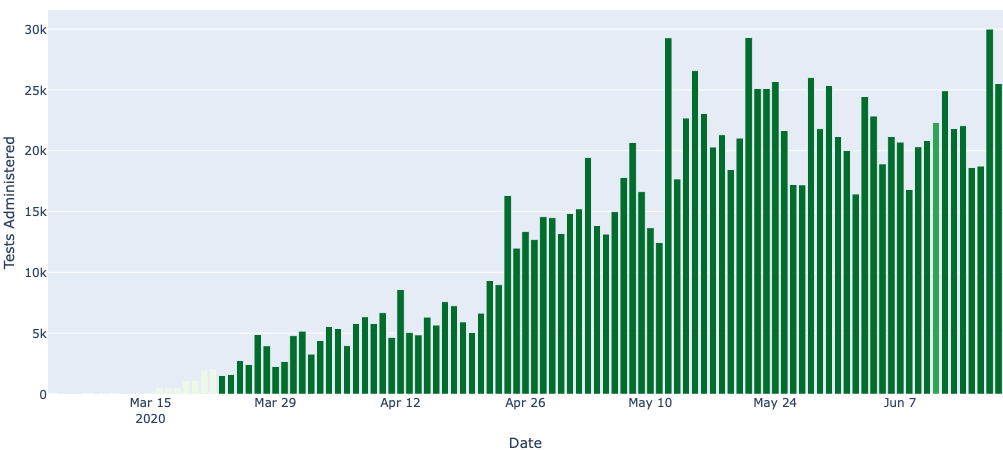

In [317]:
pio.show(create_tests_administered_plot(testing, example_json, "Illinois", "incremental"))

In [331]:
by_state = pd.read_csv("/Users/CharlesFederici/corona_python/data/by_state.csv")
by_state = by_state.iloc[:,1:-1].drop(['country_region', 'latitude', 'longitude',
                                      'recovered_pd', 'confirmed_pd', 'deaths_pd'], axis = 1) \
                                .sort_values(["province_state", 'report_date'])

states = by_state.province_state.unique().tolist()

def create_plot_cases(df, example_json, state, confirmed_or_deaths, incremental):
    df = df[df['province_state'] == state]
    if confirmed_or_deaths == "deaths":
        out_json = copy.deepcopy(example_json["incremental_plots"]["deaths"])
    else:
        out_json = copy.deepcopy(example_json["incremental_plots"]["confirmed"])

    if incremental == "incremental": 
        confirmed_or_deaths = incremental + "_" + confirmed_or_deaths
    
    out_json["data"][0]["x"] = df['report_date'].tolist()
    out_json["data"][0]["y"] = df[confirmed_or_deaths].tolist()
    out_json['data'][0]["marker"] = {}
    out_json['data'][0]["marker"]['color'] = '#494847'
    return(out_json)

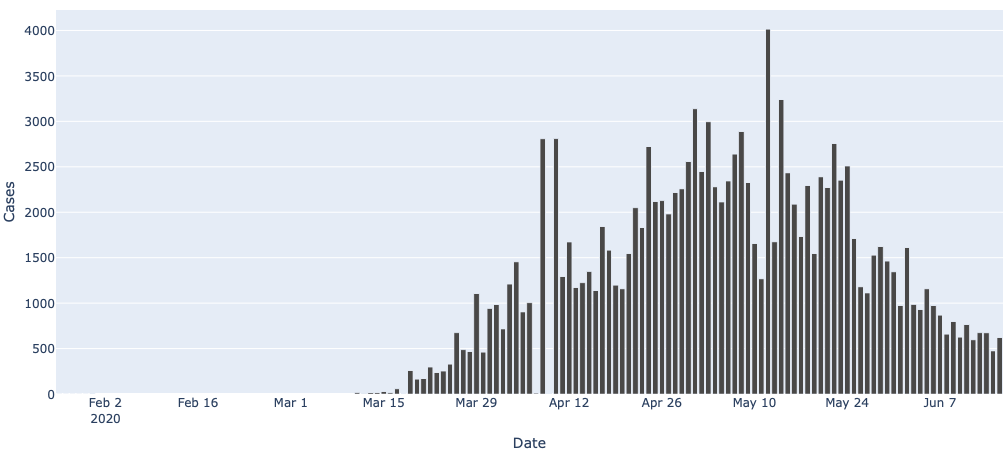

In [332]:
pio.show(create_plot_cases(by_state, example_json, "Illinois", "confirmed", "incremental"))

In [340]:


state_for_mongo = []

with open("example_master.json", "r") as read_file:
    example_json = json.load(read_file)

for state in states:
    state_json = copy.deepcopy(example_json)
    state_json["state_name"] = state
    
    for incremental in ['incremental', 'cumulative']:
        plot_type = incremental + "_plots"
        state_json[plot_type]['tests_administered'] = create_tests_administered_plot(testing, example_json, state, incremental)
        state_json[plot_type]['testing_rate'] =create_testing_rate_plot(testing, example_json, state, incremental)
        state_json[plot_type]['confirmed'] =create_plot_cases(by_state, example_json, state, "confirmed", incremental)
        state_json[plot_type]['deaths'] =create_plot_cases(by_state, example_json, state, "deaths", incremental)
    state_for_mongo.append(state_json)


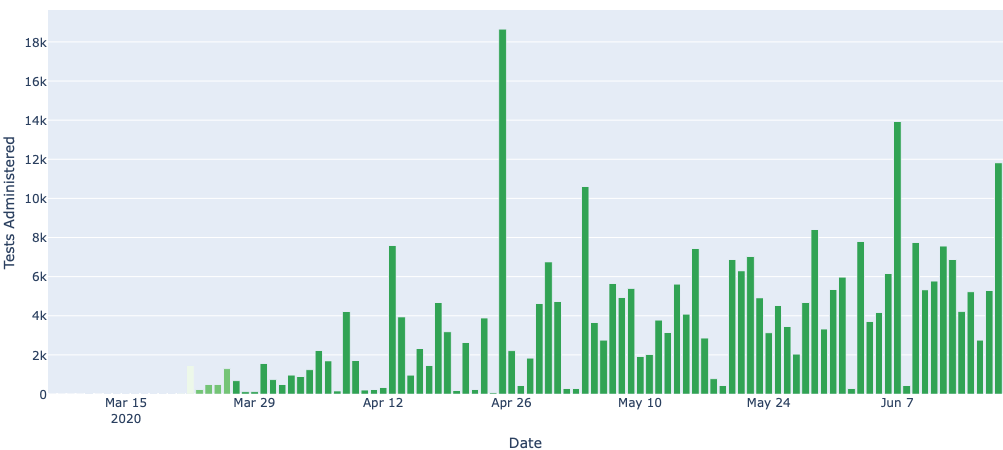

In [341]:
pio.show(state_for_mongo[0]["incremental_plots"]["tests_administered"])

# Begin Country Plots

In [362]:
by_country = pd.read_csv("/Users/CharlesFederici/corona_python/data/by_country.csv")
by_country = by_country.iloc[:,1:].sort_values(["country_region", 'report_date'])

In [363]:
by_country

,country_region,report_date,confirmed,deaths,recovered,incremental_confirmed,incremental_deaths,incremental_recovered,active,incremental_active
0,Afghanistan,2020-03-23,40.0,1.0,1.0,0.0,0.0,0.0,38.0,0.0
1,Afghanistan,2020-03-24,74.0,1.0,1.0,34.0,0.0,0.0,72.0,34.0
2,Afghanistan,2020-03-25,84.0,2.0,2.0,10.0,1.0,1.0,80.0,8.0
3,Afghanistan,2020-03-26,94.0,4.0,2.0,10.0,2.0,0.0,88.0,8.0
4,Afghanistan,2020-03-27,110.0,4.0,2.0,16.0,0.0,0.0,104.0,16.0
...,...,...,...,...,...,...,...,...,...,...
16870,Zimbabwe,2020-06-15,387.0,4.0,54.0,4.0,0.0,0.0,329.0,4.0
16871,Zimbabwe,2020-06-16,391.0,4.0,62.0,4.0,0.0,8.0,325.0,-4.0
16872,Zimbabwe,2020-06-17,401.0,4.0,63.0,10.0,0.0,1.0,334.0,9.0
16873,Zimbabwe,2020-06-18,463.0,4.0,63.0,62.0,0.0,0.0,396.0,62.0


In [454]:
with open("/Users/CharlesFederici/corona_python/example_master.json", "r") as read_file:
    example_json = json.load(read_file)

In [463]:
def create_plot_cases_us(df, example_json, country, confirmed_or_deaths, incremental):
    df = df[df['country_region'] == country]

    out_json = copy.deepcopy(example_json["incremental_plots"]["deaths"])
    
    if incremental == "incremental":
        out_json["data"][0]["y"] = df["incremental_"+confirmed_or_deaths].tolist()
    else:
        out_json["data"][0]["y"] = df[confirmed_or_deaths].tolist()
    
    out_json["data"][0]["x"] = df['report_date'].tolist()
    out_json['data'][0]["marker"] = {}
    out_json['data'][0]["marker"]['color'] = '#494847'
    
    if confirmed_or_deaths == 'confirmed':
        out_json["layout"]['yaxis']['title'] = "Confirmed Cases"
    elif confirmed_or_deaths == 'deaths':
        out_json["layout"]['yaxis']['title'] = "Deaths"
    elif confirmed_or_deaths == 'recovered':
        out_json["layout"]['yaxis']['title'] = "Recovered"
    elif confirmed_or_deaths == 'active':
        out_json["layout"]['yaxis']['title'] = "Active Cases"
    
    return(out_json)

In [464]:
metrics = ['confirmed', 'deaths', 'recovered', 'active']

incrementals = {metric:create_plot_cases_us(by_country, example_json, "US", metric, "incremental") for metric in metrics}
cumulatives = {metric:create_plot_cases_us(by_country, example_json, "US", metric, "cumulative") for metric in metrics}

country_plots = {'country_name':"US",'incremental_plots':incrementals, 'cumulative_plots':cumulatives}

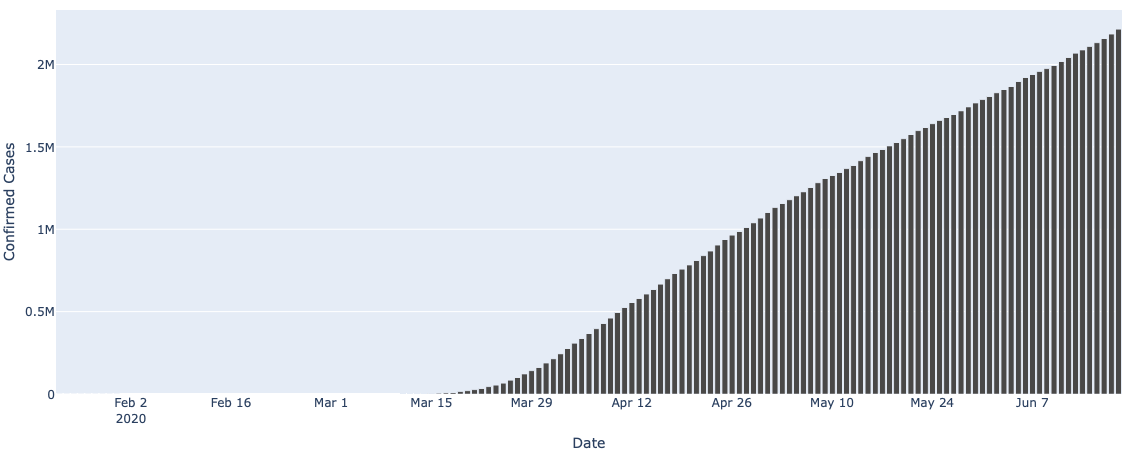

In [467]:
pio.show(country_plots["cumulative_plots"]["confirmed"])

In [387]:
state_table = by_state.merge(testing.iloc[:,1:], how="left", left_on=["province_state", 'report_date'], right_on=['state_full', 'date'])

In [418]:
date_filter = min([max(by_state['report_date']), max(testing['date'])])

cumulative_table = state_table[state_table['date'] == date_filter][['province_state', 'report_date','confirmed', 'deaths', 'positive_rate', 'dataQualityGrade']]
cumulative_table['positive_rate'] = np.round_(cumulative_table['positive_rate']*100, 1).astype(str) + "%"
cumulative_table = cumulative_table.rename({'province_state':'State', 'report_date':"Date", 'confirmed':'Cases', 'deaths':'Deaths', 'positive_rate':'%Positive', 'dataQualityGrade':'Testing-Data-Quality'},axis='columns')
cumulative_table['Incremental'] = "Cumulative"
print(cumulative_table.head())

incremental_table = state_table[state_table['date'] == date_filter][['province_state', 'report_date','incremental_confirmed', 'incremental_deaths', 'incremental_positive_rate', 'dataQualityGrade']]
incremental_table['incremental_positive_rate'] = np.round_(incremental_table['incremental_positive_rate']*100, 1).astype(str) + "%"
incremental_table = incremental_table.rename({'province_state':'State', 'report_date':"Date", 'incremental_confirmed':'Cases', 'incremental_deaths':'Deaths', 'incremental_positive_rate':'%Positive', 'dataQualityGrade':'Testing-Data-Quality'},axis='columns')
incremental_table['Incremental'] = "Incremental"
print(incremental_table.head())

          State        Date     Cases  Deaths %Positive Testing-Data-Quality  \
94      Alabama  2020-06-16   26912.0   785.0      8.8%                    B   
190      Alaska  2020-06-16     675.0    12.0      0.9%                    A   
293     Arizona  2020-06-16   39185.0  1228.0     11.0%                    A   
391    Arkansas  2020-06-16   13191.0   188.0      6.4%                    A   
494  California  2020-06-16  158961.0  5200.0      5.2%                    B   

    Incremental  
94   Cumulative  
190  Cumulative  
293  Cumulative  
391  Cumulative  
494  Cumulative  
          State        Date   Cases  Deaths %Positive Testing-Data-Quality  \
94      Alabama  2020-06-16   640.0    11.0     23.3%                    B   
190      Alaska  2020-06-16    12.0     0.0      0.7%                    A   
293     Arizona  2020-06-16  2341.0    25.0     26.4%                    A   
391    Arkansas  2020-06-16   274.0     6.0     19.2%                    A   
494  California  2020

In [480]:
df = pd.DataFrame(cumulative_table.append(incremental_table).to_dict("records"))
df = df[df["Incremental"] == "Incremental"]

states_df = pd.read_csv("/Users/CharlesFederici/corona_python/dash_app/states.csv").rename({"State":'state_full'}, axis="columns")
df = df.merge(states_df, how='left', left_on=['State'], right_on=["state_full"])
df['color_field'] = df['Cases']/max(df['Cases'])


fig = px.choropleth(df, locations="Abbreviation",
                    locationmode='USA-states',
                    scope="usa",
                    color='color_field', # lifeExp is a column of gapminder
                    hover_name="State", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.update_layout(coloraxis_showscale=False, margin_t=10, margin_b=10, margin_l=10, margin_r=10)



TypeError: Object of type Layout is not JSON serializable

In [483]:
json.loads(json.dumps([{"apple":"1", "banana":"2"}]))

[{'apple': '1', 'banana': '2'}]

In [426]:
state_table_dict_list = cumulative_table.append(incremental_table).to_dict("records")
pd.DataFrame(state_table_dict_list)

,State,Date,Cases,Deaths,%Positive,Testing-Data-Quality,Incremental
0,Alabama,2020-06-16,26912.0,785.0,8.8%,B,Cumulative
1,Alaska,2020-06-16,675.0,12.0,0.9%,A,Cumulative
2,Arizona,2020-06-16,39185.0,1228.0,11.0%,A,Cumulative
3,Arkansas,2020-06-16,13191.0,188.0,6.4%,A,Cumulative
4,California,2020-06-16,158961.0,5200.0,5.2%,B,Cumulative
...,...,...,...,...,...,...,...
97,Virginia,2020-06-16,445.0,18.0,6.9%,A,Incremental
98,Washington,2020-06-16,373.0,11.0,3.7%,B,Incremental
99,West Virginia,2020-06-16,19.0,0.0,0.8%,B,Incremental
100,Wisconsin,2020-06-16,266.0,9.0,2.4%,A,Incremental
